In [8]:
import os
import json
import math
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

/tmp/ipykernel_4240/159884441.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


## Przygotowanie danych

In [10]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="data/", train=True, transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0)

# Budowanie autoenkodera wariacyjnego 
VAE tak samo jak zwykły autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z**, oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**

Zacznijmy od stworzenia enkodera

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat
        

### Uzupełnij metodę losowania nowych przykładów w przestrzeni ukrytej

In [63]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        # `randn_like` - draw from N(0, 1) and match shape of given input
        z = torch.randn_like(mean) * var + mean
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [64]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)

# Możemy zacząć trening

In [65]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [66]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 8801.890950520834, test L1 = 0.09067768566310405
Epoch 1 loss 4348.878792526376, test L1 = 0.07969039678573608
Epoch 2 loss 3619.0164784488516, test L1 = 0.07241194788366556
Epoch 3 loss 3250.268063276242, test L1 = 0.06833971794694663
Epoch 4 loss 3011.3309034037793, test L1 = 0.06636127075180412
Epoch 5 loss 2818.6279891576523, test L1 = 0.06315903421491384
Epoch 6 loss 2655.8065425514155, test L1 = 0.06168152168393135
Epoch 7 loss 2522.312990367922, test L1 = 0.05947366077452898
Epoch 8 loss 2415.109367696648, test L1 = 0.05819943649694324
Epoch 9 loss 2325.3362739758613, test L1 = 0.05750773139297962
Epoch 10 loss 2249.4966733231504, test L1 = 0.056566577218472955
Epoch 11 loss 2186.9781076806225, test L1 = 0.05509091019630432
Epoch 12 loss 2128.130416478866, test L1 = 0.05426226174458861
Epoch 13 loss 2080.2033159304888, test L1 = 0.05360390236601233
Epoch 14 loss 2034.851762820513, test L1 = 0.053588388580828906
Epoch 15 loss 1994.050294012086, test L1 = 0.0521593148

In [67]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

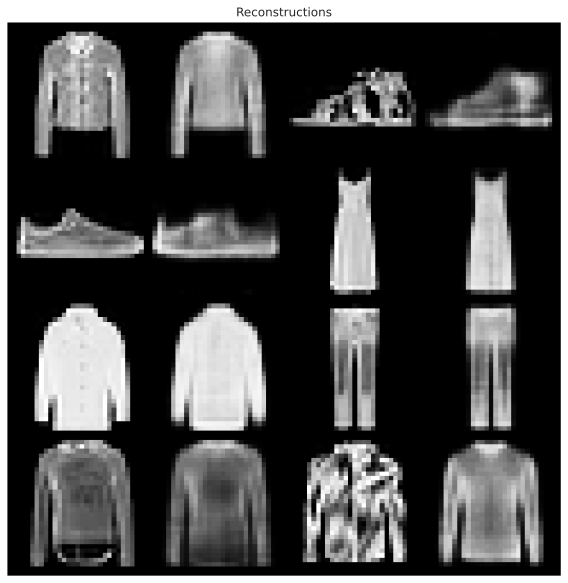

In [68]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [69]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

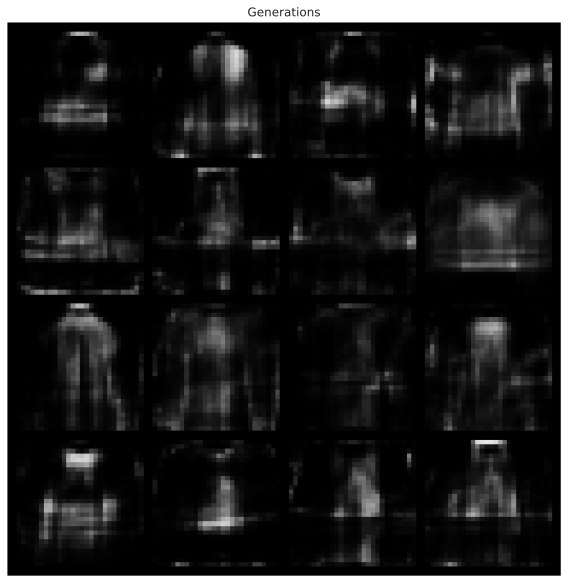

In [70]:
generate_images(vae, 16 , device)

## Co poszło nie tak?

In [71]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=784).to(device)

In [72]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [73]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [74]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 11604.172680455395, test L1 = 0.11579448971897363
Epoch 1 loss 7591.300247061966, test L1 = 0.10154640506953001
Epoch 2 loss 7011.236413678553, test L1 = 0.0935263155028224
Epoch 3 loss 6796.875747028579, test L1 = 0.09238956868648529
Epoch 4 loss 6666.328237680288, test L1 = 0.0902344012632966
Epoch 5 loss 6575.033482739049, test L1 = 0.08870887476950884
Epoch 6 loss 6503.323452941373, test L1 = 0.0879063781350851
Epoch 7 loss 6455.128820696447, test L1 = 0.08640764504671097
Epoch 8 loss 6403.887221637954, test L1 = 0.08650282509624958
Epoch 9 loss 6363.651963975694, test L1 = 0.08466766607016325
Epoch 10 loss 6329.815412994124, test L1 = 0.08429862465709448
Epoch 11 loss 6305.873837723691, test L1 = 0.0833955742418766
Epoch 12 loss 6285.037783370059, test L1 = 0.08410004377365113
Epoch 13 loss 6247.460935413328, test L1 = 0.08292449731379747
Epoch 14 loss 6229.306098090277, test L1 = 0.08292013444006444
Epoch 15 loss 6205.982503255208, test L1 = 0.08202394489198923
Epoch

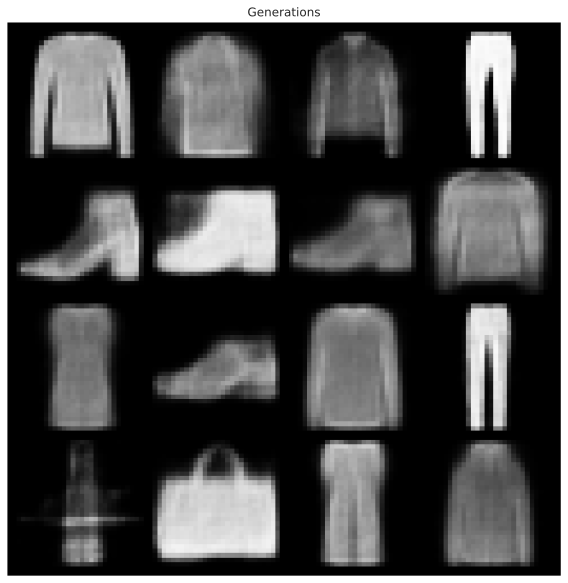

In [75]:
generate_images(vae, 16 , device)

# Przestrzeń ukryta VAE

In [76]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [79]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [80]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

In [81]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

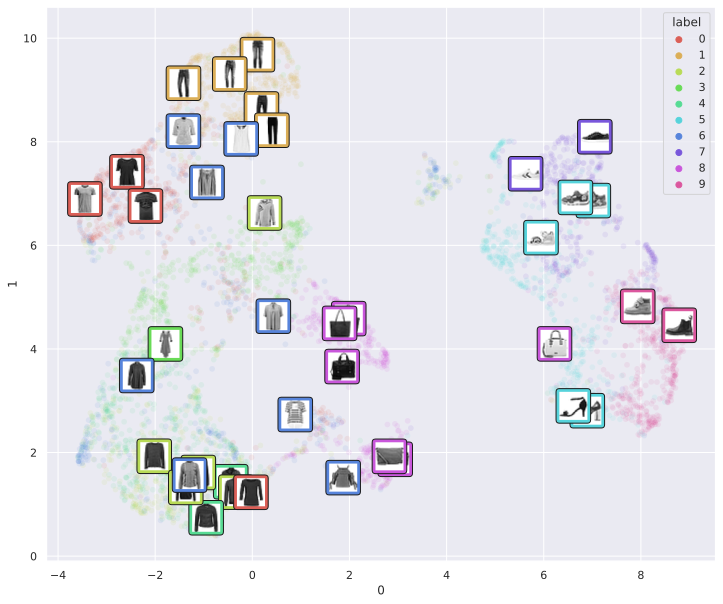

In [82]:
plot_latent(train_embedded, train_img_embeds)

In [83]:
vae = VAE(latent_dim=2, hidden_dim=256, x_dim=784).to(device)

In [84]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [85]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 10679.82323175414, test L1 = 0.11867542862892151
Epoch 1 loss 8278.459449702857, test L1 = 0.11380165573209525
Epoch 2 loss 7999.412733289931, test L1 = 0.11035232860594987
Epoch 3 loss 7767.086826422275, test L1 = 0.1089707151055336
Epoch 4 loss 7603.68550514156, test L1 = 0.10606923177838326
Epoch 5 loss 7450.106668586405, test L1 = 0.1046723099425435
Epoch 6 loss 7363.217589810363, test L1 = 0.10557255204766988
Epoch 7 loss 7304.066913311298, test L1 = 0.1029150690883398
Epoch 8 loss 7252.159173427484, test L1 = 0.10213272999972105
Epoch 9 loss 7206.340578258547, test L1 = 0.1016067810356617
Epoch 10 loss 7179.240808209803, test L1 = 0.1015825180336833
Epoch 11 loss 7143.685146233975, test L1 = 0.10199741665273905
Epoch 12 loss 7109.32275390625, test L1 = 0.10108727253973485
Epoch 13 loss 7092.920182709001, test L1 = 0.10074794236570597
Epoch 14 loss 7071.098678719284, test L1 = 0.10020997766405344
Epoch 15 loss 7048.1084714710205, test L1 = 0.0994540711864829
Epoch 16 

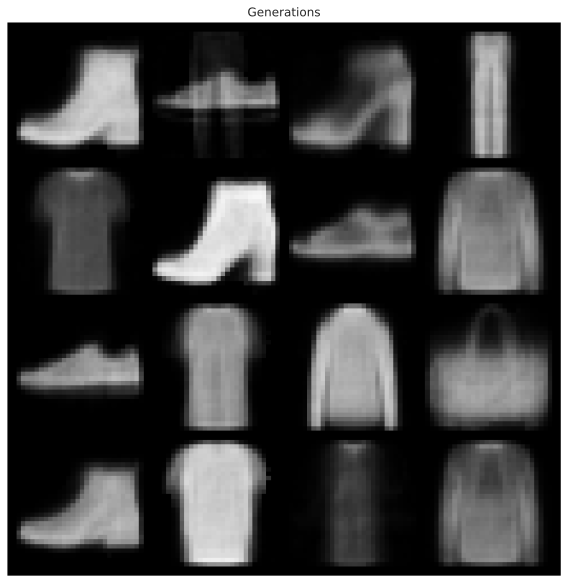

In [86]:
generate_images(vae, 16 , device)

In [87]:
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = train_img_embeds[1][:5000].cpu()

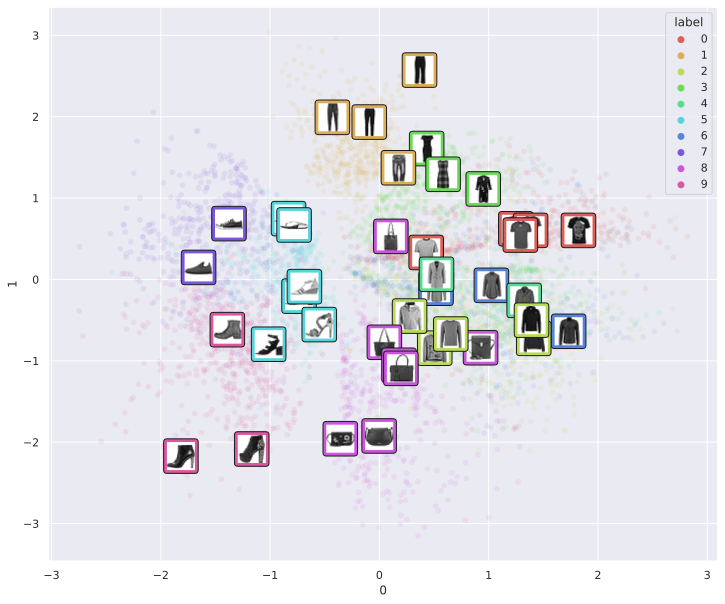

In [88]:
plot_latent(train_embedded, train_img_embeds)

<Axes: xlabel='0', ylabel='1'>

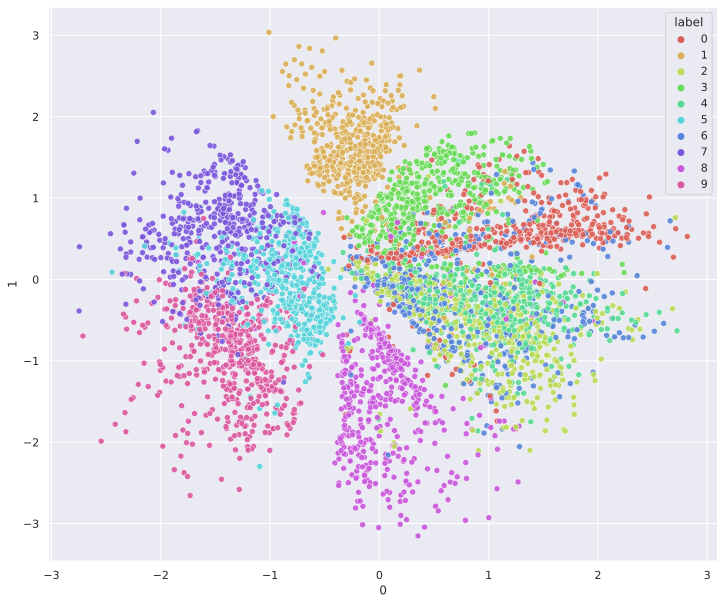

In [91]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

# Generative Adversarial Networks

In [92]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [93]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

In [94]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=784).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [95]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.0562, discriminator real acc: 0.845


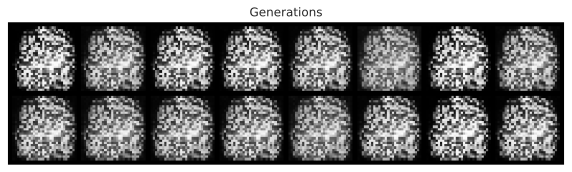

Epoch: 1, discrimiantor fake error: 0.0334, discriminator real acc: 0.941
Epoch: 2, discrimiantor fake error: 0.0244, discriminator real acc: 0.96
Epoch: 3, discrimiantor fake error: 0.00672, discriminator real acc: 0.98
Epoch: 4, discrimiantor fake error: 0.00194, discriminator real acc: 0.992
Epoch: 5, discrimiantor fake error: 0.00155, discriminator real acc: 0.995
Epoch: 6, discrimiantor fake error: 0.00172, discriminator real acc: 0.997
Epoch: 7, discrimiantor fake error: 0.005, discriminator real acc: 0.995
Epoch: 8, discrimiantor fake error: 0.0158, discriminator real acc: 0.986
Epoch: 9, discrimiantor fake error: 0.0248, discriminator real acc: 0.979
Epoch: 10, discrimiantor fake error: 0.0177, discriminator real acc: 0.979


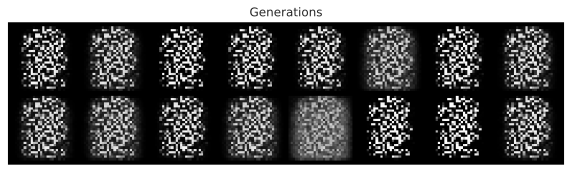

Epoch: 11, discrimiantor fake error: 0.0106, discriminator real acc: 0.987
Epoch: 12, discrimiantor fake error: 0.00904, discriminator real acc: 0.991
Epoch: 13, discrimiantor fake error: 0.0342, discriminator real acc: 0.976
Epoch: 14, discrimiantor fake error: 0.0681, discriminator real acc: 0.94
Epoch: 15, discrimiantor fake error: 0.0215, discriminator real acc: 0.97
Epoch: 16, discrimiantor fake error: 0.019, discriminator real acc: 0.978
Epoch: 17, discrimiantor fake error: 0.039, discriminator real acc: 0.964
Epoch: 18, discrimiantor fake error: 0.0513, discriminator real acc: 0.952
Epoch: 19, discrimiantor fake error: 0.0388, discriminator real acc: 0.959
Epoch: 20, discrimiantor fake error: 0.0426, discriminator real acc: 0.961


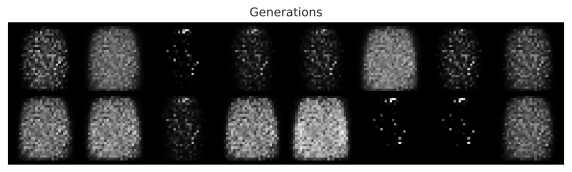

Epoch: 21, discrimiantor fake error: 0.0529, discriminator real acc: 0.947
Epoch: 22, discrimiantor fake error: 0.0415, discriminator real acc: 0.955
Epoch: 23, discrimiantor fake error: 0.0375, discriminator real acc: 0.959
Epoch: 24, discrimiantor fake error: 0.0347, discriminator real acc: 0.961
Epoch: 25, discrimiantor fake error: 0.0374, discriminator real acc: 0.962
Epoch: 26, discrimiantor fake error: 0.0484, discriminator real acc: 0.953
Epoch: 27, discrimiantor fake error: 0.0429, discriminator real acc: 0.955
Epoch: 28, discrimiantor fake error: 0.0427, discriminator real acc: 0.956
Epoch: 29, discrimiantor fake error: 0.0423, discriminator real acc: 0.955
Epoch: 30, discrimiantor fake error: 0.0509, discriminator real acc: 0.951


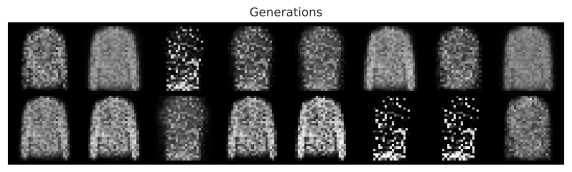

Epoch: 31, discrimiantor fake error: 0.0558, discriminator real acc: 0.945
Epoch: 32, discrimiantor fake error: 0.0605, discriminator real acc: 0.941
Epoch: 33, discrimiantor fake error: 0.0721, discriminator real acc: 0.935
Epoch: 34, discrimiantor fake error: 0.0625, discriminator real acc: 0.936
Epoch: 35, discrimiantor fake error: 0.072, discriminator real acc: 0.935
Epoch: 36, discrimiantor fake error: 0.084, discriminator real acc: 0.92
Epoch: 37, discrimiantor fake error: 0.0911, discriminator real acc: 0.916
Epoch: 38, discrimiantor fake error: 0.0846, discriminator real acc: 0.919
Epoch: 39, discrimiantor fake error: 0.0752, discriminator real acc: 0.928
Epoch: 40, discrimiantor fake error: 0.0713, discriminator real acc: 0.929


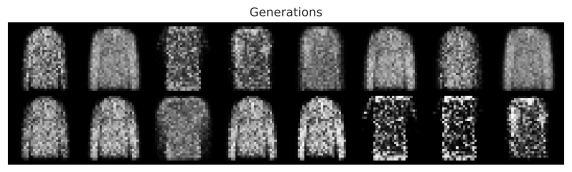

Epoch: 41, discrimiantor fake error: 0.064, discriminator real acc: 0.936
Epoch: 42, discrimiantor fake error: 0.0842, discriminator real acc: 0.921
Epoch: 43, discrimiantor fake error: 0.0972, discriminator real acc: 0.907
Epoch: 44, discrimiantor fake error: 0.0935, discriminator real acc: 0.913
Epoch: 45, discrimiantor fake error: 0.0953, discriminator real acc: 0.911
Epoch: 46, discrimiantor fake error: 0.0878, discriminator real acc: 0.915
Epoch: 47, discrimiantor fake error: 0.0861, discriminator real acc: 0.92
Epoch: 48, discrimiantor fake error: 0.0841, discriminator real acc: 0.922
Epoch: 49, discrimiantor fake error: 0.0784, discriminator real acc: 0.922
Epoch: 50, discrimiantor fake error: 0.0852, discriminator real acc: 0.922


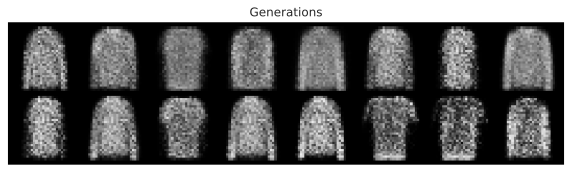

Epoch: 51, discrimiantor fake error: 0.0903, discriminator real acc: 0.913
Epoch: 52, discrimiantor fake error: 0.0892, discriminator real acc: 0.917
Epoch: 53, discrimiantor fake error: 0.0899, discriminator real acc: 0.916
Epoch: 54, discrimiantor fake error: 0.0857, discriminator real acc: 0.919
Epoch: 55, discrimiantor fake error: 0.0875, discriminator real acc: 0.921
Epoch: 56, discrimiantor fake error: 0.0862, discriminator real acc: 0.915
Epoch: 57, discrimiantor fake error: 0.0788, discriminator real acc: 0.923
Epoch: 58, discrimiantor fake error: 0.0784, discriminator real acc: 0.925
Epoch: 59, discrimiantor fake error: 0.0773, discriminator real acc: 0.925
Epoch: 60, discrimiantor fake error: 0.0783, discriminator real acc: 0.923


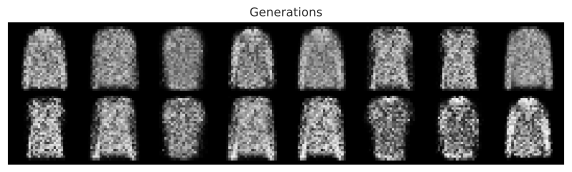

Epoch: 61, discrimiantor fake error: 0.0799, discriminator real acc: 0.919
Epoch: 62, discrimiantor fake error: 0.0829, discriminator real acc: 0.92
Epoch: 63, discrimiantor fake error: 0.0909, discriminator real acc: 0.915
Epoch: 64, discrimiantor fake error: 0.097, discriminator real acc: 0.907
Epoch: 65, discrimiantor fake error: 0.0955, discriminator real acc: 0.908
Epoch: 66, discrimiantor fake error: 0.104, discriminator real acc: 0.902
Epoch: 67, discrimiantor fake error: 0.108, discriminator real acc: 0.899
Epoch: 68, discrimiantor fake error: 0.109, discriminator real acc: 0.897
Epoch: 69, discrimiantor fake error: 0.108, discriminator real acc: 0.896
Epoch: 70, discrimiantor fake error: 0.11, discriminator real acc: 0.894


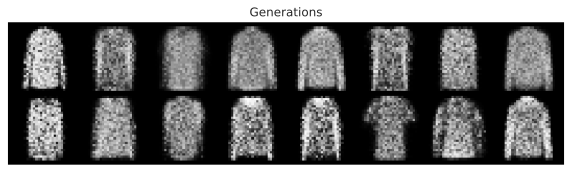

Epoch: 71, discrimiantor fake error: 0.11, discriminator real acc: 0.898
Epoch: 72, discrimiantor fake error: 0.118, discriminator real acc: 0.887
Epoch: 73, discrimiantor fake error: 0.108, discriminator real acc: 0.891
Epoch: 74, discrimiantor fake error: 0.113, discriminator real acc: 0.894
Epoch: 75, discrimiantor fake error: 0.113, discriminator real acc: 0.89
Epoch: 76, discrimiantor fake error: 0.116, discriminator real acc: 0.885
Epoch: 77, discrimiantor fake error: 0.126, discriminator real acc: 0.877
Epoch: 78, discrimiantor fake error: 0.13, discriminator real acc: 0.879
Epoch: 79, discrimiantor fake error: 0.134, discriminator real acc: 0.869
Epoch: 80, discrimiantor fake error: 0.131, discriminator real acc: 0.868


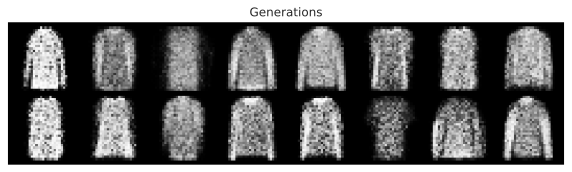

Epoch: 81, discrimiantor fake error: 0.134, discriminator real acc: 0.867
Epoch: 82, discrimiantor fake error: 0.136, discriminator real acc: 0.864
Epoch: 83, discrimiantor fake error: 0.14, discriminator real acc: 0.863
Epoch: 84, discrimiantor fake error: 0.139, discriminator real acc: 0.867
Epoch: 85, discrimiantor fake error: 0.139, discriminator real acc: 0.855
Epoch: 86, discrimiantor fake error: 0.137, discriminator real acc: 0.862
Epoch: 87, discrimiantor fake error: 0.136, discriminator real acc: 0.865
Epoch: 88, discrimiantor fake error: 0.136, discriminator real acc: 0.861
Epoch: 89, discrimiantor fake error: 0.133, discriminator real acc: 0.868
Epoch: 90, discrimiantor fake error: 0.142, discriminator real acc: 0.857


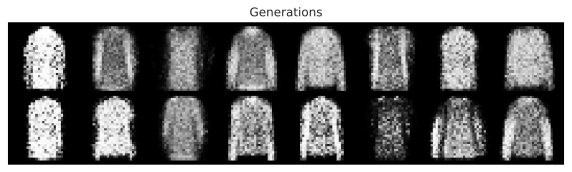

Epoch: 91, discrimiantor fake error: 0.136, discriminator real acc: 0.86
Epoch: 92, discrimiantor fake error: 0.126, discriminator real acc: 0.877
Epoch: 93, discrimiantor fake error: 0.127, discriminator real acc: 0.875
Epoch: 94, discrimiantor fake error: 0.128, discriminator real acc: 0.871
Epoch: 95, discrimiantor fake error: 0.129, discriminator real acc: 0.87
Epoch: 96, discrimiantor fake error: 0.137, discriminator real acc: 0.866
Epoch: 97, discrimiantor fake error: 0.137, discriminator real acc: 0.866
Epoch: 98, discrimiantor fake error: 0.134, discriminator real acc: 0.865
Epoch: 99, discrimiantor fake error: 0.128, discriminator real acc: 0.87


In [96]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

## Stwórzmy model warunkowany klasą
Może się przydać F.one_hot

In [ ]:
from torch.nn.functional import one_hot

In [ ]:
one_hot(torch.tensor([4,3,4]),10)

# Ewaluacja modeli generatywnych

In [97]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(28*28, 256).to(device)

In [98]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [99]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [100]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(test_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

Correctly guessed  87.16000000000001 % of the dataset


In [103]:
vae = vae_32

NameError: name 'vae_32' is not defined

In [104]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    fixed_labels = torch.randint(10,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, 10).float()
#     generations_cond_gan = cond_generator(fixed_noise, fixed_labels)
    generations_gan = generator(fixed_noise)
    generations_vae = vae.decoder(fixed_noise)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x32 and 2x256)

In [105]:
orig_data = [x[0] for x in list(test_set)[:1000]]
orig_data = torch.cat(orig_data)

In [106]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()
#     dist_cond_gan = evaluator.get_features(generations_cond_gan.to(device)).cpu()

NameError: name 'generations_vae' is not defined

In [ ]:
for idx in range(5):
    bins = 10
    w = 0.3
    plt.figure(figsize=(10,10))
    plt.hist([dist_orig_data[:,idx].numpy(),dist_vae[:,idx].numpy(),dist_gan[:,idx]], bins, alpha=0.5, label=['orig','vae','gan','cond_gan'],width=w)
    plt.legend(loc='upper right')
    plt.show();
    plt.close()

In [ ]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
orig_data_2 = [x[0] for x in list(test_set)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [ ]:
for name, obj in zip(['orig','vae','gan','cond_gan'],[dist_orig_data_2.numpy(),dist_vae.numpy(),dist_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")